## Import libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import itertools

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [52]:
torch.__version__

'1.11.0+cu102'

## Setting

In [2]:
DPATH = "/projectnb2/dl523/students/ziwhuang/Project/data"
label_map = {"cat": 0, "dog": 1}
unzip = False

## Load the data

In [3]:
if unzip:

    # unzip the dataset
    import zipfile

    with zipfile.ZipFile("/projectnb2/dl523/students/ziwhuang/Project/data/train.zip","r") as zipf:
        zipf.extractall(DPATH)

    with zipfile.ZipFile("/projectnb2/dl523/students/ziwhuang/Project/data/test1.zip", "r") as zipf:
        zipf.extractall(DPATH)

In [4]:
# save the directories of the datasets to variables
train_dir = os.path.join(DPATH,"train")
test_dir = os.path.join(DPATH,"test1")

# check the format of the data
train_image_names = os.listdir(train_dir)
test_image_names = os.listdir(test_dir)

#random_choice = np.random.randint(low=0,high=100,size=5)
print(train_image_names[:3])
print(test_image_names[:3])

['cat.9820.jpg', 'dog.3435.jpg', 'dog.11656.jpg']
['2374.jpg', '8500.jpg', '9295.jpg']


## Tidying data

In [5]:
# 0 for cat ,1 for dog
all_categories = []
images = os.listdir(train_dir)
for file in images:
    if file.split('.')[0] == 'dog':
        all_categories.append(1)
    else:
        all_categories.append(0)
#creat data fram to save each image with its label 
df =pd.DataFrame({
    'image': images,
    'category':all_categories
})

#conver label to categorical in stead of numerical value to use feature of image generator 
df['category'] = df['category'].replace({1:'dog',0:'cat'})
df.head(10)

,image,category
0,cat.9820.jpg,cat
1,dog.3435.jpg,dog
2,dog.11656.jpg,dog
3,dog.5776.jpg,dog
4,dog.10457.jpg,dog
5,dog.9119.jpg,dog
6,cat.11339.jpg,cat
7,dog.4007.jpg,dog
8,cat.214.jpg,cat
9,cat.2954.jpg,cat


In [6]:
print(df['category'].value_counts())

cat    12500
dog    12500
Name: category, dtype: int64


In [7]:
# make lists of dataset images with their full path
import glob

train_images = glob.glob(os.path.join(train_dir, "*.jpg"))
test_images = glob.glob(os.path.join(test_dir, "*.jpg" ))

print(train_images[:3])
print(len(train_images))
print(test_images[:3])
print(len(test_images))

['/projectnb2/dl523/students/ziwhuang/Project/data/train/cat.9820.jpg', '/projectnb2/dl523/students/ziwhuang/Project/data/train/dog.3435.jpg', '/projectnb2/dl523/students/ziwhuang/Project/data/train/dog.11656.jpg']
25000
['/projectnb2/dl523/students/ziwhuang/Project/data/test1/2374.jpg', '/projectnb2/dl523/students/ziwhuang/Project/data/test1/8500.jpg', '/projectnb2/dl523/students/ziwhuang/Project/data/test1/9295.jpg']
12500


## Define a Pytorch `Dataset` class for retrieving the images in the dataset

In [8]:
# make a dataset class
class CatDogDataset(Dataset):
    
    def __init__(self, images_list, mode="train", transform=None):
        self.images_list = images_list
        self.mode = mode
        self.transform = transform
        
    # dataset length
    def __len__(self):
        self.dataset_len = len(self.images_list)
        return self.dataset_len
    
    # load an image
    def __getitem__(self, idx):
        image_name = self.images_list[idx]
        image = Image.open(image_name)
        image = image.resize((224,224)) # this is important when feeding into a pretrained model
        transformed_image = self.transform(image)
        image_category = image_name.split("/")[-1].split(".")[0]
        
        if self.mode == "train" or self.mode == "valid":
            if image_category == "cat":
                label = 0 
            else:
                label = 1              
            return transformed_image, label
        else:
            return transformed_image

## Define transformations to normalize/augment the images

In [9]:
# define transformations for the train, test and holdout images
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224, scale=(0.8,1.0),ratio=(1.0,1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0, 0, 0),(1, 1, 1))
    ])

# for validation we only need to normalize the data
valid_transforms = transforms.Compose([ 
        transforms.ToTensor(),
        transforms.Normalize((0, 0, 0),(1, 1, 1))
    ])

## Split the labeled train data into training and validation sets|

In [10]:
from sklearn.model_selection import train_test_split

train_list, valid_list = train_test_split(train_images, test_size=0.2)

## Prepare the datasets for training

In [12]:
# create dataset objects
train_dataset = CatDogDataset(train_list, transform=train_transforms)
valid_dataset = CatDogDataset(valid_list, mode="valid", transform=valid_transforms)
test_dataset = CatDogDataset(test_images, mode="valid", transform=valid_transforms)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

torch.Size([128, 3, 224, 224])
torch.Size([128])


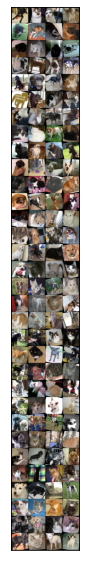

In [14]:
## look at a batch
train_iter = iter(train_loader)
images, labels = train_iter.next()
print(images.shape)
print(labels.shape)

# visualize several random images
for images, labels in train_loader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))
    break

## Define a CNN model

In [44]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=0, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # here image dim would be 220/2 = 110
            
            # convolutional layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=0, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # here image dim would be 116/2 = 58
            
            # convolutional layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # here image dim would be 54/2 = 27
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 24 * 24, out_features=256),
            nn.ReLU(),

            
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            
            
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            
            
            nn.Linear(in_features=64, out_features=16),
            nn.ReLU(),
            
            
            nn.Linear(in_features=16, out_features=2)
            
        )
    
    def forward(self, x):
        out = self.cnn_layers(x)
        #print(out.shape)
        out = out.view(-1, 64 * 24 * 24) # flatten the values
        out = self.linear_layers(out)
        return out


In [45]:
# instantiate the model
net = CNN()

In [47]:
criterion = nn.CrossEntropyLoss() # applies log_softmax and then NLLLoss cost function
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=36864, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1

## Training

In [48]:
training_loss=[]
iteration = [] 

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        ## -- ! code required  
        images, labels = data 
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        out = net(images)
        loss = criterion(out, labels)
        loss.backward() 
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            iteration.append(i+1+epoch*2000)
            training_loss.append(running_loss / 2000)
            
            running_loss = 0.0
            


print('Finished Training')

Finished Training


## Validation

In [49]:
def validation_on_Cats_vs_Dogs(net, valid_loader):
    
    correct = 0 
    
    total = 0 
    
    ## -- ! code required  
    with torch.no_grad():
        
        for data in valid_loader: 
            
            images,labels = data 
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _,predict = torch.max(outputs.data,1)
            total += labels.size(0)
            correct +=(predict ==labels).sum().item()
    
    acc = correct/total*100 
        
    return acc

In [50]:
acc = validation_on_Cats_vs_Dogs(net, valid_loader)
print(f"Validation accuracy of the network on the {len(valid_dataset)} validation images: {acc} % ")

Validation accuracy of the network on the 5000 validation images: 70.5 % 
